# Explore Data


In [19]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf

SILVER_QA_PATH = '/lakehouse/default/Files/silver/igra2/qa'
SILVER_STATION_LIST_PATH = '/lakehouse/default/Files/silver/igra2/doc/igra2-station-list.csv'

In [82]:
# Get CSV files list from a folder
csv_files = glob.glob(SILVER_QA_PATH + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Pandas doesn't like to concatinate "empty" DataFrames
df_list = [dataframe for dataframe in df_list if dataframe.shape[0] > 0]

# Concatenate all DataFrames
df = pd.concat(df_list, ignore_index=True)

del df_list

df.head()

,id,effective_date,hour,usable_10k,usable_all,max_gph,min_pa
0,USM00072249,2000-01-01,0,24,63,28956.0,1300
1,USM00072249,2000-01-01,12,39,68,24114.0,2780
2,USM00072249,2000-01-02,0,1,1,198.0,98590
3,USM00072249,2000-01-02,12,42,44,10594.0,25000
4,USM00072249,2000-01-03,0,37,53,30775.0,1000


In [13]:
df_stations = pd.read_csv(SILVER_STATION_LIST_PATH)
df_stations.head()

,id,latitude,longitude,elevation,state,name,fst_year,lst_year,nobs
0,ACM00078861,17.1170,-61.7830,10.0,NaN,COOLIDGE FIELD (UA),1947,1993,13896
1,AEM00041217,24.4333,54.6500,16.0,NaN,ABU DHABI INTERNATIONAL AIRPOR,1983,2023,39662
2,AEXUAE05467,25.2500,55.3700,4.0,NaN,SHARJAH,1935,1942,2477
3,AFM00040911,36.7000,67.2000,378.0,NaN,MAZAR-I-SHARIF,2010,2014,2179
4,AFM00040913,36.6667,68.9167,433.0,NaN,KUNDUZ,2010,2013,4540


In [3]:
print(f"Total Observation Count: {df.shape[0]}")

Total Observation Count: 346607


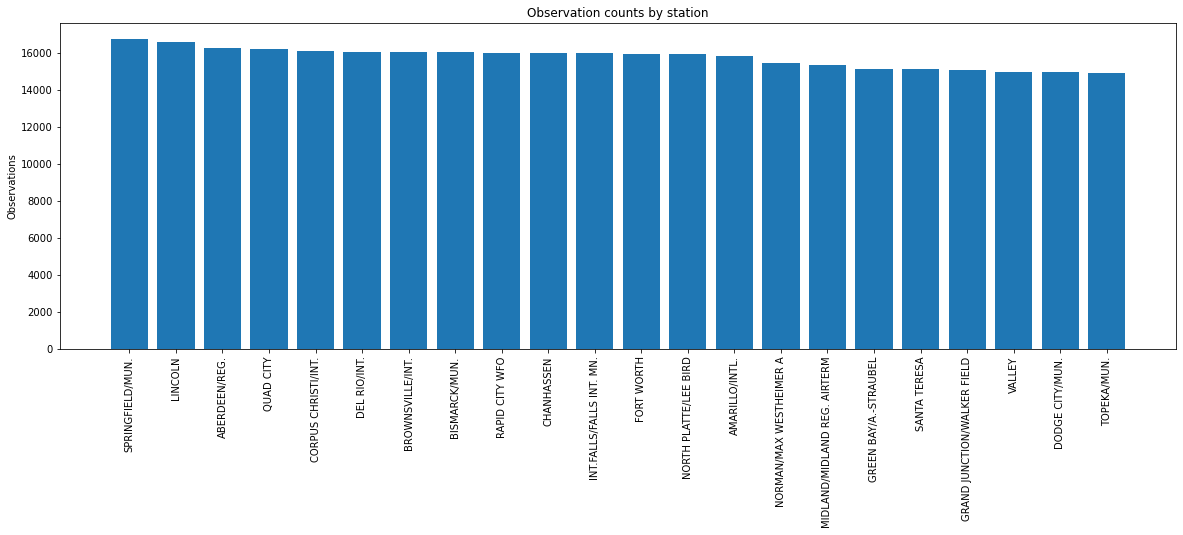

In [35]:
query = sqldf('''
    SELECT s.name, COUNT(*) AS station_rows
    FROM df q
    INNER JOIN df_stations s on q.id = s.id 
    GROUP BY s.name
    ORDER BY station_rows DESC''')

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(query.name, query.station_rows)
ax.set_ylabel('Observations')
ax.set_title('Observation counts by station')
ax.tick_params(axis='x', labelrotation=90)

plt.show()

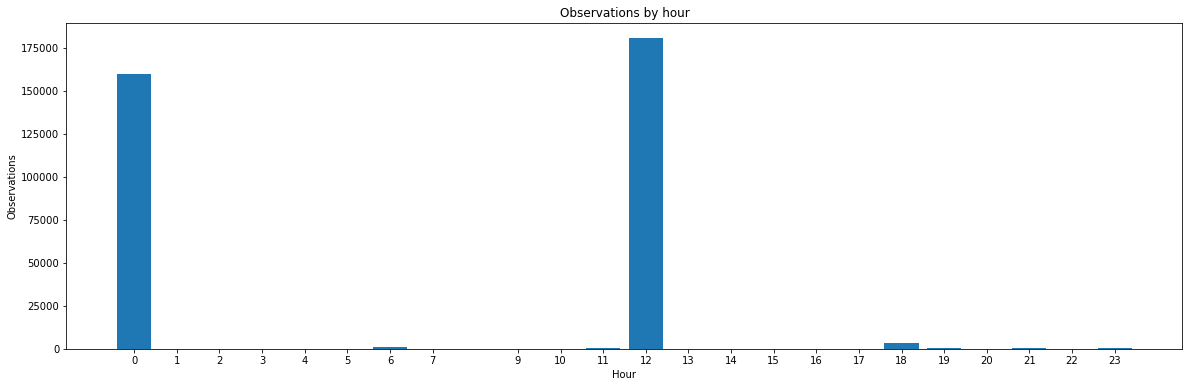

In [44]:
query = sqldf('''
    SELECT hour, COUNT(*) AS obs_count
    FROM df 
    GROUP BY hour''')

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(query.hour, query.obs_count)
ax.set_ylabel('Observations')
ax.set_xlabel('Hour')
ax.set_title('Observations by hour')
ax.set_xticks(query.hour) # Force to show all x-values
# ax.set_yscale('log')

plt.show()

In [81]:
# Need Pandas to calculate the standard deviation
query = df[df.hour == 12] \
    .groupby('id') \
    .agg({'usable_10k': ['mean', 'std']})
query.columns=['mean', 'stdev']

# Now build a query using the standard deviation
query = sqldf('''
    SELECT
        s.name
        ,round(mean, 1) as avg_usable_10k
        ,round(mean - stdev, 1) as usable_10k_68
        ,round(mean - 2.0 * stdev, 1) as usable_10k_95
    FROM query q
    INNER JOIN df_stations s on q.id = s.id 
    GROUP BY s.name
    ORDER BY avg_usable_10k DESC''')

query

,name,avg_usable_10k,usable_10k_68,usable_10k_95
0,BROWNSVILLE/INT.,47.4,29.7,12.0
1,CORPUS CHRISTI/INT.,45.3,31.6,17.9
2,QUAD CITY,45.1,27.9,10.8
3,TOPEKA/MUN.,44.5,28.1,11.7
4,NORMAN/MAX WESTHEIMER A,44.0,25.7,7.4
5,DEL RIO/INT.,43.0,22.0,1.0
6,INT.FALLS/FALLS INT. MN.,40.3,27.8,15.3
7,SPRINGFIELD/MUN.,39.2,28.0,16.8
8,FORT WORTH,38.3,28.2,18.1
9,LINCOLN,38.2,27.9,17.5


In [ ]:
%%sql
select
    s.name
    ,count(*) as total_count
    ,sum(if(usable_10k < 20, 1, 0)) as thrown_out_count
    ,round(sum(if(usable_10k < 20, 1, 0)) / count(*) * 100.0, 1) as pct
from igra2_s_data_por_qa qa
inner join igra2_s_station_list s
    on s.id = qa.id
where hour = 12
group by s.name
order by pct desc;

In [ ]:
%%sql
select
    s.name as label
    ,min(usable_10k) as whislo
    ,percentile(usable_10k, 0.25) as q1
    ,percentile(usable_10k, 0.5) as med
    ,percentile(usable_10k, 0.75) as q3
    ,max(usable_10k) as whishi
from igra2_s_data_por_qa qa
inner join igra2_s_station_list s on qa.id = s.id
where hour = 12
group by s.name
order by med

In [ ]:
df = spark.sql("""select
    s.name as label
    ,min(usable_10k) as whislo
    ,percentile(usable_10k, 0.25) as q1
    ,percentile(usable_10k, 0.5) as med
    ,percentile(usable_10k, 0.75) as q3
    ,max(usable_10k) as whishi
from igra2_s_data_por_qa qa
inner join igra2_s_station_list s on qa.id = s.id
where hour = 12
group by s.name
order by med""").toPandas()

In [ ]:
boxes = []

for index, row in df.iterrows():
    boxes.append({
        'label' : row.label,
        'whislo': row.whislo,   # Bottom whisker position
        'q1'    : row.q1,       # First quartile (25th percentile)
        'med'   : row.med,      # Median         (50th percentile)
        'q3'    : row.q3,       # Third quartile (75th percentile)
        'whishi': row.whishi,   # Top whisker position
        'fliers': []            # Outliers
    })

fig, ax = plt.subplots()
ax.bxp(boxes, showfliers=False)
ax.set_ylabel("usable_10k")
plt.xticks(rotation=90)

In [ ]:
%%sql
select
    s.name
    ,round(avg(max_gph) / 1000.0, 1) as avg_max_gph
    ,round((avg(max_gph) - std(max_gph)) / 1000.0, 1) as gph_68
    ,round((avg(max_gph) - 2.0 * std(max_gph)) / 1000.0, 1) as gph_95
from igra2_s_data_por_qa qa
inner join igra2_s_station_list s on s.id = qa.id
group by s.name
order by avg_max_gph desc